LSTM model for predicting (unfiltered) shear stress

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(1)

import tensorflow as tf
#tf.random.set_seed(2)


Using TensorFlow backend.


In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [3]:
# Load the data

data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/p5270MechData/p5270MechData.mat')

m_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'ShearStress':data2['ShearStress'].ravel()})
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'A_filt':data1['A_filt'].ravel(), 'V_filt':data1['V_filt'].ravel(),
                    'T_pc':data1['T_pc'].ravel(), 'Vel_pc':data1['Vel_pc'].ravel(), 'T_der':data1['T_der'].ravel(), 'Vel_der':data1['Vel_der'].ravel()}) # 7 features
                   #'T_off':data1['T_off'].ravel(), 'Vel_off':data1['Vel_off'].ravel()})   

df = a_t.merge(m_t, on='Time')

print("Input data:", df.shape)


Input data: (132399, 8)


In [4]:
# Preprocessing

df = df.drop(['Time', 'T_der', 'Vel_der'], axis=1)  # Drop irrelevant features 

arr = df.to_numpy()
n_steps = 3
xdf, ydf = create_timesteps(arr, n_steps)

# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95325, 3, 4)
Validation: (10592, 3, 4)
Testing: (26480, 3, 4)


Train on 95325 samples, validate on 10592 samples
Epoch 1/20
95325/95325 [==============================] - 27s 285us/step - loss: 0.3129 - val_loss: 0.0031
Epoch 2/20
95325/95325 [==============================] - 26s 278us/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/20
95325/95325 [==============================] - 26s 276us/step - loss: 0.0042 - val_loss: 0.0038
Epoch 4/20
95325/95325 [==============================] - 26s 273us/step - loss: 0.0041 - val_loss: 0.0021
Epoch 5/20
95325/95325 [==============================] - 26s 274us/step - loss: 0.0039 - val_loss: 0.0045
Epoch 6/20
95325/95325 [==============================] - 26s 274us/step - loss: 0.0038 - val_loss: 0.0022
Epoch 7/20
95325/95325 [==============================] - 26s 273us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 8/20
95325/95325 [==============================] - 26s 275us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 9/20
95325/95325 [==============================] - 27s 279us/step - loss: 0.0033 - val_

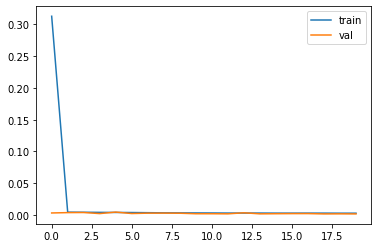

In [5]:
# Build the model

model = Sequential()
model.add(LSTM(256, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(TimeDistributed(Dense(64, kernel_initializer='normal', activation='relu')))
model.add(Flatten())
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [6]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

y_predTest = model.predict(x_test)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))


R2 scores: Train - 0.85773, Validation - 0.92680, Test - 0.86248
RMSE scores: Train - 0.04916, Validation - 0.04030, Test - 0.05469


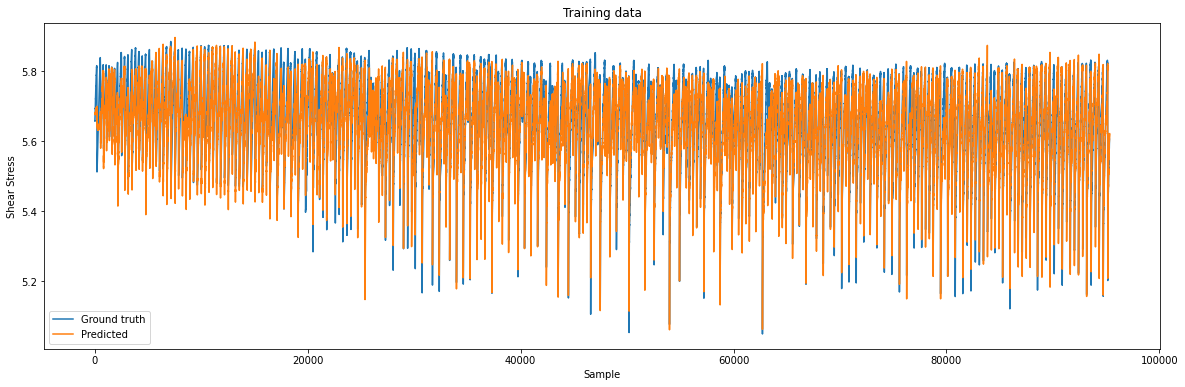

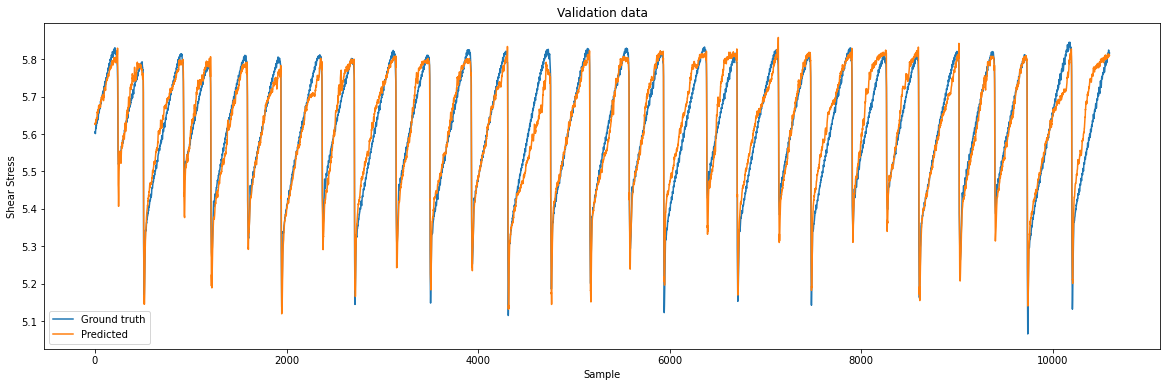

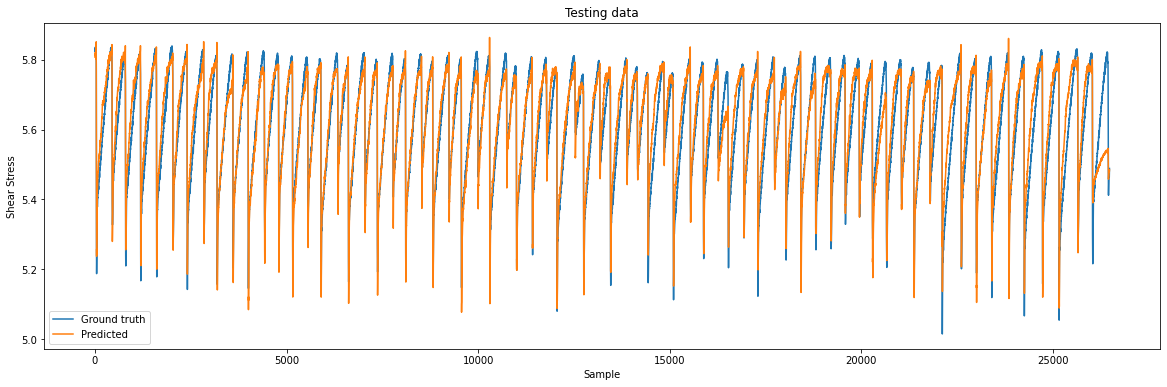

In [7]:
# Results plot

def results_plot(fig_no, gt, pred, title):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Sample')
  plt.ylabel('Shear Stress')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data')
results_plot(2, Y_val, y_predVal, 'Validation data')
results_plot(3, y_test, y_predTest, 'Testing data')


Text(0.5, 1.0, '5000 Samples, Testing Data')

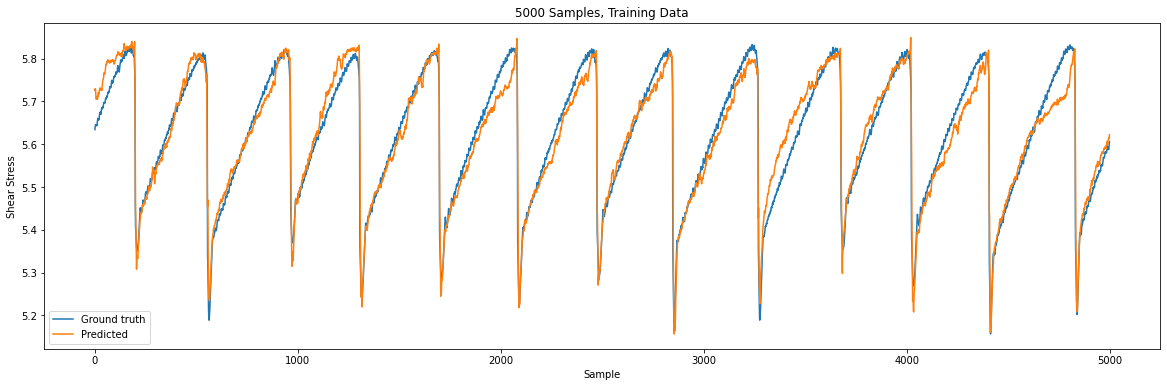

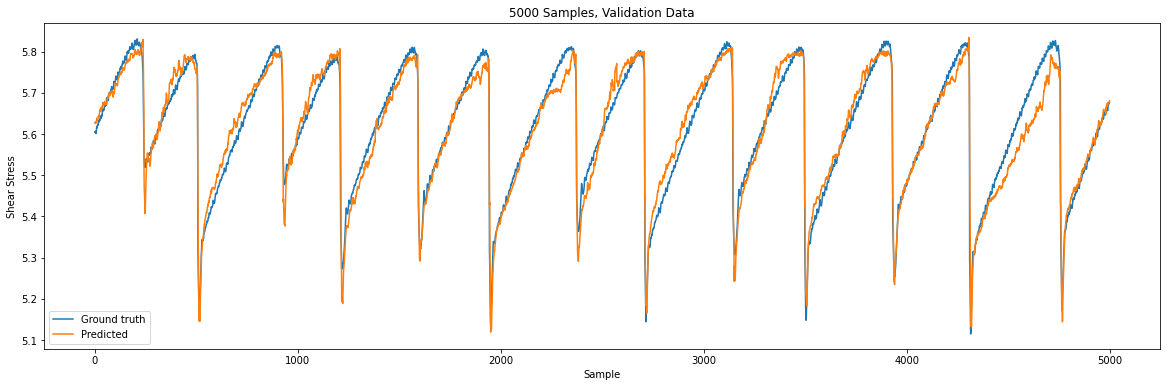

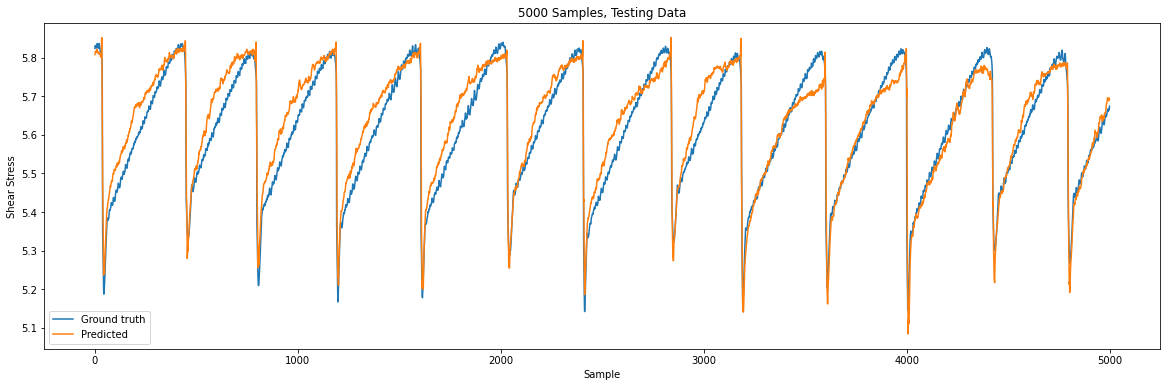

In [8]:
# Detailed view of the plots

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-5000:])
plt.plot(y_predTrain[-5000:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:5000])
plt.plot(y_predVal[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:5000])
plt.plot(y_predTest[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Testing Data')
